In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'Sensor4SV'
os.environ['KAGGLE_KEY'] = '8aeff9da4a93f597bd7d7d0d1aa156e6'

!kaggle datasets download -d hlrhegemony/pokemon-image-dataset

Dataset URL: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset
License(s): CC0-1.0
pokemon-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!unzip -q pokemon-image-dataset.zip -d pokemon

In [ ]:
# 2. Imports
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image

# 3. Paths and device
data_dir = '/content/pokemon/images'  # Указываем директорию с папками-покемонами
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. Transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# 5. Verify data_dir structure
print(f"Listing subdirectories in {data_dir}:", os.listdir(data_dir))

# 6. Create full dataset to get class info and indices
full_dataset = ImageFolder(data_dir)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# 7. Split indices reproducibly
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()
train_idx, test_idx = indices[:train_size], indices[train_size:]

# 8. Create train/test subsets with respective transforms
train_dataset = Subset(ImageFolder(data_dir, transform=train_transform), train_idx)
test_dataset = Subset(ImageFolder(data_dir, transform=test_transform), test_idx)

# 9. DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Listing subdirectories in /content/pokemon/images: ['Corvisquire', 'Aggron', 'Ledyba', 'Xatu', 'Anorith', 'Tropius', 'Lombre', 'Dewgong', 'Purugly', 'Falinks', 'Sandshrew', 'Tyranitar', 'Solosis', 'Espurr', 'Magcargo', 'Coalossal', 'Marshadow', 'Silicobra', 'Electrike', 'Drampa', 'Shiftry', 'Scrafty', 'Spiritomb', 'Roggenrola', "Farfetch'd", 'Clefable', 'Boltund', 'Serperior', 'Dustox', 'Lileep', 'Gyarados', 'Lillipup', 'Inteleon', 'Inkay', 'Giratina', 'Gardevoir', 'Dubwool', 'Houndoom', 'Arcanine', 'Cufant', 'Aipom', 'Grimer', 'Drednaw', 'Bastiodon', 'Ferrothorn', 'Fomantis', 'Oshawott', 'Surskit', 'Pheromosa', 'Ledian', 'Miltank', 'Raikou', 'Kyogre', 'Sunflora', 'Slowbro', 'Pichu', 'Sentret', 'Hatterene', 'Shuckle', 'Duraludon', 'Walrein', 'Luxray', 'Dragonite', 'Mantine', 'Noibat', 'Thwackey', 'Noivern', 'Diggersby', 'Clobbopus', 'Cosmog', 'Fraxure', 'Obstagoon', 'Magmortar', 'Centiskorch', 'Tapu Bulu', 'Claydol', 'Muk', 'Tauros', 'Karrablast', 'Jumpluff', 'Orbeetle', 'Spheal', 'Unf

In [ ]:
# 10. Define CNN model
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

model = PokemonCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 2
train_losses, train_accs = [], []

In [ ]:
# 11. Training loop
for epoch in range(1, epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")


Epoch 1/2 - Loss: 6.8354 - Acc: 0.0015
Epoch 2/2 - Loss: 6.7969 - Acc: 0.0025


In [ ]:
# 12. Evaluate on test set
model.eval()
running_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_loss = running_loss / total
    test_acc = correct / total
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.4f}")

Test Loss: 6.8143 - Test Acc: 0.0020


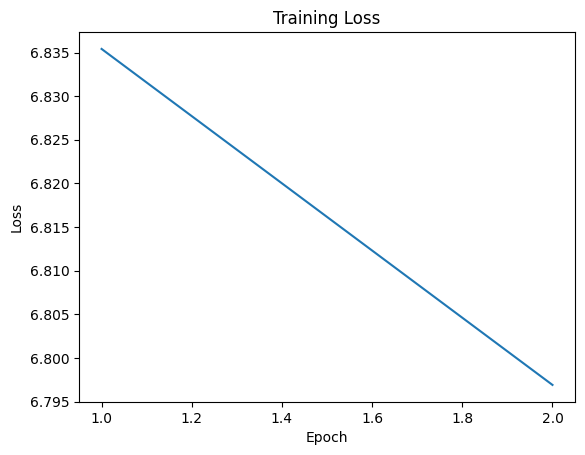

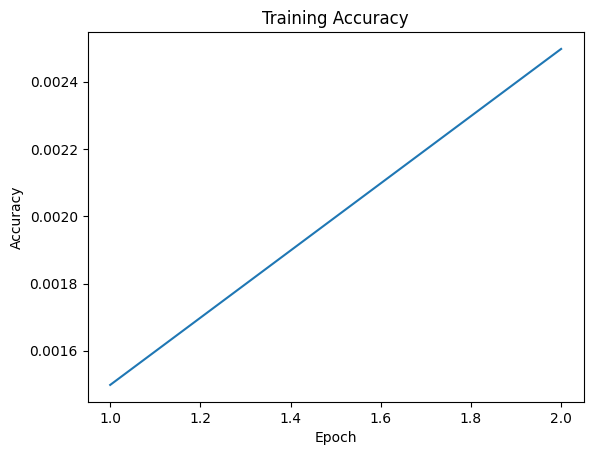

In [ ]:
# 13. Plot training metrics
plt.figure()
plt.plot(range(1, epochs + 1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(range(1, epochs + 1), train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Saved model state_dict to pokemon_cnn_state_dict.pth


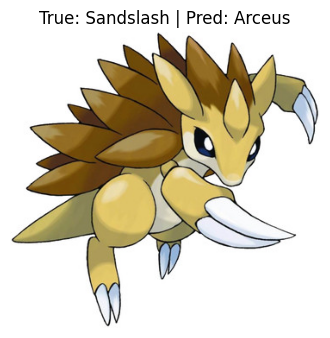

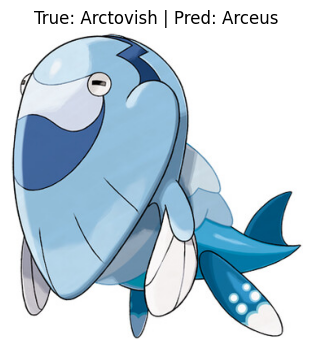

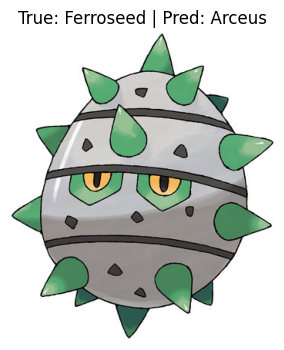

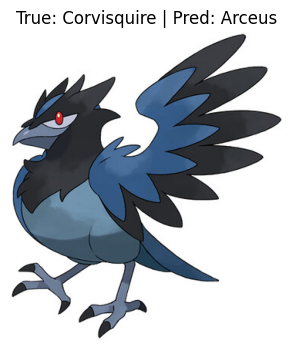

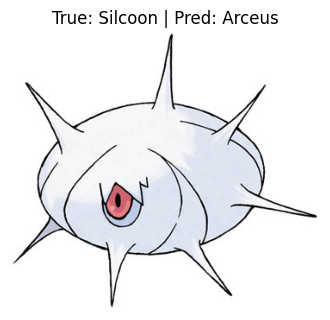

In [ ]:
import random
# 14. Save model state_dict
model_path = 'pokemon_cnn_state_dict.pth'
torch.save(model.state_dict(), model_path)
print(f"Saved model state_dict to {model_path}")

# 15. Demo: Random samples from class folders with true vs predicted labels
# Number of samples to display
num_samples = 5
# Load model for demo
demo_model = PokemonCNN(num_classes).to(device)
demo_model.load_state_dict(torch.load(model_path))
demo_model.eval()

# For reproducibility
random.seed(42)

# Collect random samples
samples = []
for _ in range(num_samples):
    cls = random.choice(class_names)
    cls_dir = os.path.join(data_dir, cls)
    img_file = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_file)
    samples.append((cls, img_path))

# Display
for true_label, img_path in samples:
    orig = Image.open(img_path).convert('RGB')
    inp = test_transform(orig).unsqueeze(0).to(device)
    with torch.no_grad():
        out = demo_model(inp)
        pred_idx = out.argmax(dim=1).item()
    pred_label = class_names[pred_idx]
    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(orig)
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

пупупу. точность так себе. но я слышал, у некоторых похуже. Можно заметить, что модель всегда выдает один и тот же предикт. Была мысль, что это из - за дисбаланса классов, но оказалось неправда. на 10 эпохах лучше не было, еще больше вряд ли сильно улучшит, а времени и так много требует.